In [1]:
from tensorflow.keras import layers, models, backend, utils, metrics, preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics as skmetrics
import numpy as np
import seaborn as sns
import os
import pandas as pd
import glob
import errno
import scipy
from scipy import ndimage
import imageio


In [6]:
DIR_PREFIX  = '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/'

def load_dataset(path):
    dataset = {"image_path":[],"img_status":[],"where":[]}
    for status in os.listdir(path):
        for image in glob.glob(path+"/"+status+"/"+"*.jpg"):
            dataset["image_path"].append(image)
            dataset["img_status"].append(status)
            dataset["where"].append("train")
    dataset = pd.DataFrame(dataset)
    dataset.value_counts("img_status")
    real = dataset.value_counts("img_status")[1]
    fake = dataset.value_counts("img_status")[0]

    print(f"Real: {real},\nFake: {fake}\n")
    sns.countplot(dataset["img_status"])
    plt.show()
    return dataset

def view_dataset(dataset):
    plt.figure(figsize = (14,10))
    for i in range(9):
        random = np.random.randint(1,len(dataset))
        plt.subplot(3,3,i+1)
        plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
        plt.title(dataset.loc[random, "img_status"], size = 10) 
        plt.xticks([])
        plt.yticks([])

    plt.show()
    
def predict(img_path):
    input_arr = []
    count = 0
    image = preprocessing.image.load_img(
        img_path, grayscale=False, color_mode="rgb", target_size=(224, 224, 3)
    )
    i = preprocessing.image.img_to_array(image)
    input_arr = np.array([i])
    predictions = model.predict(input_arr)
    return predictions[0]

def predict_dataset(dataset):
    plt.figure(figsize = (14,10))
    for i in range(9):
        random = np.random.randint(1,len(dataset))
        plt.subplot(3,3,i+1)
        plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
        predicted = predict(dataset.loc[random,"image_path"]);
        plt.title(f"{dataset.loc[random, 'img_status']} accuracy: {predicted}", size = 10) 
        plt.xticks([])
        plt.yticks([])
    

def rotate_image(dir_name='train', deg=35):
    try:
        os.mkdir('./output/'+dir_name)
        os.mkdir('./output/'+dir_name+'/fake')
        os.mkdir('./output/'+dir_name+'/real')
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass
    i = 0
    print('data processed for '+dir_name)
    for filename in os.listdir(DIR_PREFIX+dir_name):
        f = os.path.join(DIR_PREFIX+dir_name, filename)
        # checking if it is a file
        if os.path.isdir(f):
            rotate_image(dir_name+'/'+filename, deg)
        else:
            i = i+1
            with Image.open(f) as im:
                im = im.rotate(deg)
                im.save(f.replace(DIR_PREFIX,'./output/'))
            print(i, end='\r')
            
try:
    os.mkdir('./output')
except OSError as exc:
    pass

In [ ]:
path  = '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/train'
train_dataset = load_dataset(path)

In [ ]:
view_dataset(train_dataset)

In [7]:
rotate_image('valid', 30)
rotate_image('train', 30)


data processed for valid
data processed for valid/fake
data processed for valid/real
data processed for train
data processed for train/fake
data processed for train/real


Real: 1000,
Fake: 1000



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


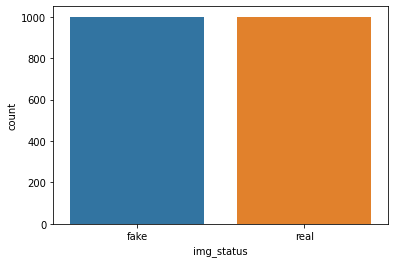

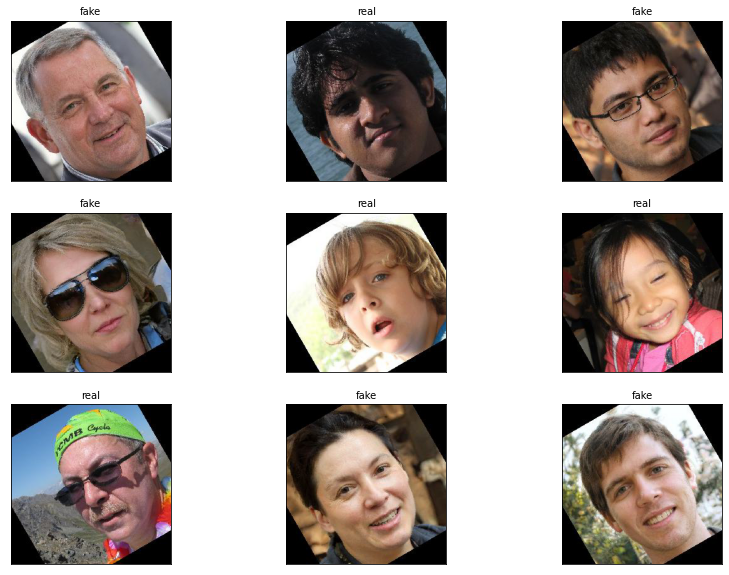

In [8]:
path  = './output/valid'
train_dataset_preprocessed = load_dataset(path)
view_dataset(train_dataset_preprocessed)

In [9]:
base_path = './output/'
train_flow = preprocessing.image_dataset_from_directory(
    base_path + 'train/',
    image_size=(224, 224),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
test_flow = preprocessing.image_dataset_from_directory(
    '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/test',
    image_size=(224, 224),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
valid_flow = preprocessing.image_dataset_from_directory(
    base_path + 'valid/',
    image_size=(224, 224),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
train_flow.class_names

Found 8000 files belonging to 2 classes.


2022-07-05 15:18:02.596972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 15:18:02.729145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 15:18:02.730501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 15:18:02.736807: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 3587 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


['fake', 'real']

In [10]:
model = models.Sequential()

model.add(
    layers.Conv2D(32, (3, 3),activation='relu', input_shape=(224, 224, 3))
)

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
# output node 1 means prediction in 0 -- 1 and decimals
# output node 2 means predication of 0 or 1 no decimals
model.summary()

model.compile(
    optimizer = 'adam', 
    loss = 'binary_crossentropy', 
    metrics = [
        'accuracy'
    ]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       2

In [12]:
train_steps = 4000//64
valid_steps = 4000//64

hist = model.fit(
    train_flow,
    epochs=10,
    validation_data=valid_flow,
    batch_size=64
)

Epoch 1/10
125/125 [==============================] - 14s 112ms/step - loss: 0.4317 - accuracy: 0.8048 - val_loss: 0.5431 - val_accuracy: 0.7255
Epoch 2/10
125/125 [==============================] - 15s 119ms/step - loss: 0.4051 - accuracy: 0.8159 - val_loss: 0.5676 - val_accuracy: 0.7405
Epoch 3/10
125/125 [==============================] - 14s 110ms/step - loss: 0.3842 - accuracy: 0.8279 - val_loss: 0.5810 - val_accuracy: 0.7305
Epoch 4/10
125/125 [==============================] - 14s 112ms/step - loss: 0.3578 - accuracy: 0.8451 - val_loss: 0.5772 - val_accuracy: 0.7540
Epoch 5/10
125/125 [==============================] - 14s 111ms/step - loss: 0.3277 - accuracy: 0.8536 - val_loss: 0.6218 - val_accuracy: 0.7490
Epoch 6/10
125/125 [==============================] - 15s 113ms/step - loss: 0.3129 - accuracy: 0.8648 - val_loss: 0.6083 - val_accuracy: 0.7505
Epoch 7/10
125/125 [==============================] - 15s 115ms/step - loss: 0.2724 - accuracy: 0.8849 - val_loss: 0.6170 - val_ac

In [13]:
y_pred = model.predict(test_flow)
y_pred

array([[0.9993734 ],
       [0.9894713 ],
       [0.9951892 ],
       ...,
       [0.99981874],
       [0.9956403 ],
       [0.9952435 ]], dtype=float32)

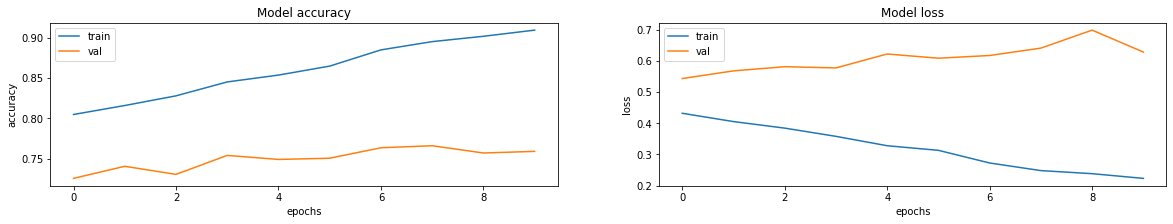

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate([ "accuracy", "loss"]):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [ ]:
# path  = '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/test'
# test_dataset = load_dataset(path)
# predict_dataset(test_dataset)